Training started...

Epoch 1/20 | Loss: 7.5992
Epoch 2/20 | Loss: 1.0250
Epoch 3/20 | Loss: 0.6216
Epoch 4/20 | Loss: 0.5939
Epoch 5/20 | Loss: 0.5904
Epoch 6/20 | Loss: 0.5445
Epoch 7/20 | Loss: 0.5664
Epoch 8/20 | Loss: 0.5464
Epoch 9/20 | Loss: 0.5759
Epoch 10/20 | Loss: 0.5676
Epoch 11/20 | Loss: 0.5576
Epoch 12/20 | Loss: 0.5691
Epoch 13/20 | Loss: 0.5319
Epoch 14/20 | Loss: 0.5246
Epoch 15/20 | Loss: 0.5359
Epoch 16/20 | Loss: 0.5174
Epoch 17/20 | Loss: 0.5648
Epoch 18/20 | Loss: 0.5180
Epoch 19/20 | Loss: 0.5531
Epoch 20/20 | Loss: 0.5023

Test Accuracy: 0.9200
Confusion Matrix:
 [[240  25]
 [ 15 220]]


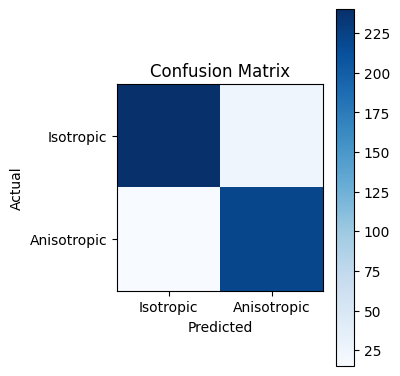

[SAVE] Training stats saved -> train_stats_256.npz


In [ ]:
import os
import scipy.io
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# ================== CONFIG ==================
DATA_DIR = 'DN_Matrix_Batch_new'  # your folder
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
TEST_SPLIT = 0.5        # 50% for training
INPUT_NOISE_LEVEL = 0.1 # Stronger noise for training
LABEL_NOISE_FRAC = 0.05 # Flip 5% of labels
# =============================================
# ============ Dataset Class =================
class DNMatrixDataset(Dataset):
    def __init__(self, folder, label_noise_frac=0.0):
        features = []
        labels = []
        files = sorted(os.listdir(folder))
        for file in files:
            if file.endswith('.mat'):
                path = os.path.join(folder, file)
                mat_data = scipy.io.loadmat(path)
                dn_matrix = mat_data['DN_noisy']
                dn_matrix = np.nan_to_num(dn_matrix)
                dn_matrix = dn_matrix.flatten().astype(np.float32)
                label = int(mat_data['label'].squeeze())
                features.append(dn_matrix)
                labels.append(label)

        features_array = np.array(features)
        labels_array = np.array(labels)

        # Introduce label noise
        if label_noise_frac > 0:
            n_noisy = int(label_noise_frac * len(labels_array))
            noisy_idx = np.random.choice(len(labels_array), n_noisy, replace=False)
            for idx in noisy_idx:
                labels_array[idx] = 1 - labels_array[idx]  # flip 0 ↔ 1

        self.features = torch.tensor(features_array, dtype=torch.float32)
        self.labels = torch.tensor(labels_array, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# ============ Model =================
class AnisotropyClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(256, 16),   # smaller hidden layer
            nn.ReLU(),
            nn.Dropout(0.5),      # 50% dropout
            nn.Linear(16, 2)
        )

    def forward(self, x):
        return self.network(x)

# Load dataset with label noise
dataset = DNMatrixDataset(DATA_DIR, label_noise_frac=LABEL_NOISE_FRAC)

# Split dataset
test_size = int(TEST_SPLIT * len(dataset))
train_size = len(dataset) - test_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, loss, optimizer
model = AnisotropyClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ============ Training Loop ============
print("Training started...\n")
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        # Add strong input noise (train only)
        noisy_features = features + INPUT_NOISE_LEVEL * torch.randn_like(features)

        optimizer.zero_grad()
        outputs = model(noisy_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {epoch_loss / len(train_loader):.4f}")

# ============ Evaluation ============
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device) # no noise for testing
        outputs = model(features)
        _, predicted = torch.max(outputs, dim=1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)

# ============ Visualization ============
plt.figure(figsize=(4, 4))
plt.imshow(conf_matrix, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0, 1], ['Isotropic', 'Anisotropic'])
plt.yticks([0, 1], ['Isotropic', 'Anisotropic'])
plt.colorbar()
plt.tight_layout()
plt.show()
# ===== Save training mean/std for inference =====
X_all = dataset.features.numpy()
mean = X_all.mean(axis=0, keepdims=True)
std = X_all.std(axis=0, keepdims=True)
np.savez("train_stats_256.npz", mean=mean, std=std)
print("[SAVE] Training stats saved -> train_stats_256.npz")




In [ ]:
# Save entire model
torch.save(model.state_dict(), 'ann_anisotropy_classifier.pth')
print("Model saved successfully.")


Model saved successfully.



Test Accuracy : 0.9333
F1 Score      : 0.9333
Precision     : 0.9333
Recall        : 0.9333

Confusion Matrix:
[[231  16]
 [ 17 231]]


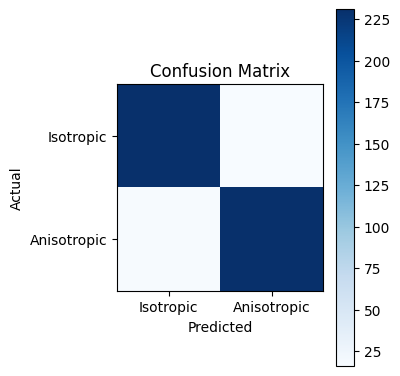

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

# Evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, dim=1)

        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

# Metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')  # 'weighted' handles class imbalance
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

# Print results
print(f"\nTest Accuracy : {accuracy:.4f}")
print(f"F1 Score      : {f1:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualization
plt.figure(figsize=(4, 4))
plt.imshow(conf_matrix, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0, 1], ['Isotropic', 'Anisotropic'])
plt.yticks([0, 1], ['Isotropic', 'Anisotropic'])
plt.colorbar()
plt.tight_layout()
plt.show()
